In [1]:
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is {device}')

Current device is cuda


In [3]:
data_dir = './indoor_outdoor_dataset/'

Посмотрим на параметры картинок

(256, 256, 3)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

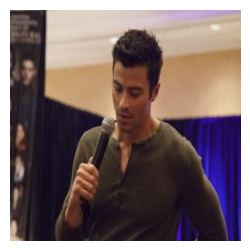

In [4]:
image = cv2.imread(data_dir + 'indoor/' + '00000001_51011.jpg')
print(image.shape)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(3,3))
plt.imshow(image_rgb)
plt.axis('off')

Загрузим датасет полностью

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
])

In [6]:
full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(full_data))
val_size = int(0.1 * len(full_data))
test_size = len(full_data) - train_size - val_size

train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])

In [7]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [8]:
train_data[9][0].shape

torch.Size([3, 256, 256])

Получим baseline

In [9]:
class Baseline_CNN(nn.Module):
    def __init__(self):
        super(Baseline_CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [10]:
# Для логирования в Tensorboard
writer = SummaryWriter('runs/cats_vs_dogs_experiment_1')

In [11]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, writer=None, model_filename='cnn_best_checkpoint.pth'):
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc='Пакеты', position=0, leave=True):
            # clear_output(wait=True)
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
        

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, model_filename)

In [12]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy

In [13]:
model = Baseline_CNN()

model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer)

Пакеты: 100%|██████████| 10264/10264 [23:13<00:00,  7.37it/s]


Epoch [1/20], Loss: 0.3205, Accuracy: 0.8687, Val Loss: 0.2704, Val Accuracy: 0.8923
Validation accuracy improved from 0.0000 to 0.8923. Saving model...


Пакеты: 100%|██████████| 10264/10264 [14:58<00:00, 11.42it/s]


Epoch [2/20], Loss: 0.2597, Accuracy: 0.8989, Val Loss: 0.2491, Val Accuracy: 0.9006
Validation accuracy improved from 0.8923 to 0.9006. Saving model...


Пакеты: 100%|██████████| 10264/10264 [14:50<00:00, 11.53it/s]


Epoch [3/20], Loss: 0.2394, Accuracy: 0.9087, Val Loss: 0.2477, Val Accuracy: 0.9002


Пакеты: 100%|██████████| 10264/10264 [14:49<00:00, 11.53it/s]


Epoch [4/20], Loss: 0.2152, Accuracy: 0.9184, Val Loss: 0.2572, Val Accuracy: 0.9069
Validation accuracy improved from 0.9006 to 0.9069. Saving model...


Пакеты: 100%|██████████| 10264/10264 [14:54<00:00, 11.47it/s]


Epoch [5/20], Loss: 0.1938, Accuracy: 0.9277, Val Loss: 0.2421, Val Accuracy: 0.9040


Пакеты: 100%|██████████| 10264/10264 [14:47<00:00, 11.57it/s]


Epoch [6/20], Loss: 0.1713, Accuracy: 0.9382, Val Loss: 0.2817, Val Accuracy: 0.9017


Пакеты: 100%|██████████| 10264/10264 [14:47<00:00, 11.56it/s]


Epoch [7/20], Loss: 0.1533, Accuracy: 0.9470, Val Loss: 0.3377, Val Accuracy: 0.8953


Пакеты: 100%|██████████| 10264/10264 [14:49<00:00, 11.54it/s]


Epoch [8/20], Loss: 0.1346, Accuracy: 0.9538, Val Loss: 0.3592, Val Accuracy: 0.9029


Пакеты: 100%|██████████| 10264/10264 [14:50<00:00, 11.52it/s]


Epoch [9/20], Loss: 0.1230, Accuracy: 0.9587, Val Loss: 0.3270, Val Accuracy: 0.8975


Пакеты: 100%|██████████| 10264/10264 [14:50<00:00, 11.53it/s]


Epoch [10/20], Loss: 0.1127, Accuracy: 0.9632, Val Loss: 0.4932, Val Accuracy: 0.8999


Пакеты: 100%|██████████| 10264/10264 [14:51<00:00, 11.52it/s]


Epoch [11/20], Loss: 0.1077, Accuracy: 0.9655, Val Loss: 0.4522, Val Accuracy: 0.9006


Пакеты: 100%|██████████| 10264/10264 [14:53<00:00, 11.49it/s]


Epoch [12/20], Loss: 0.1065, Accuracy: 0.9670, Val Loss: 0.4048, Val Accuracy: 0.8985


Пакеты: 100%|██████████| 10264/10264 [14:49<00:00, 11.55it/s]


Epoch [13/20], Loss: 0.1058, Accuracy: 0.9687, Val Loss: 0.4702, Val Accuracy: 0.8984


Пакеты: 100%|██████████| 10264/10264 [14:48<00:00, 11.55it/s]


Epoch [14/20], Loss: 0.0947, Accuracy: 0.9710, Val Loss: 0.6420, Val Accuracy: 0.8947


Пакеты: 100%|██████████| 10264/10264 [15:23<00:00, 11.11it/s]


Epoch [15/20], Loss: 0.0930, Accuracy: 0.9719, Val Loss: 0.5193, Val Accuracy: 0.8992


Пакеты:  57%|█████▋    | 5861/10264 [09:10<06:53, 10.65it/s]


KeyboardInterrupt: 

### Результаты эксперимента с Baseline_CNN  
![Alt text](images/exp1_acc.png)   
![Alt text](images/exp1_loss.png)

Как можно заметить: какой-то вменяемый результат был достигнут только на 4-й эпохе, после чего качество стало падать

### Попробуем провести эксперименты с данными

В этот момент я вспомнил, что хорошо бы зафиксировать seed :)

In [13]:
def seed_everything(seed: int):
    # Для генератора случайных чисел Python
    random.seed(seed)
    
    # Для numpy
    np.random.seed(seed)
    
    # Для torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

In [14]:
train_data[2][0].numpy().shape

(3, 256, 256)

Напишем функцию для визуализации картинок

In [15]:
def visualize_pic(dataset, idxs):
    count = len(idxs)
    rows = int(np.ceil(count / 5))
    cols = int(np.ceil(count / rows))
        
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        
    if not isinstance(axes, np.ndarray):
        axes = [axes] 
    else:
        axes = axes.flatten()  
    
    for i in range(len(axes)):
        if i < len(idxs):
            img = dataset[idxs[i]][0].permute(1, 2, 0).numpy()
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb / 2 + 0.5)  # Пример графика sin(x + i)
            axes[i].set_title(f'Pic {idxs[i]}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

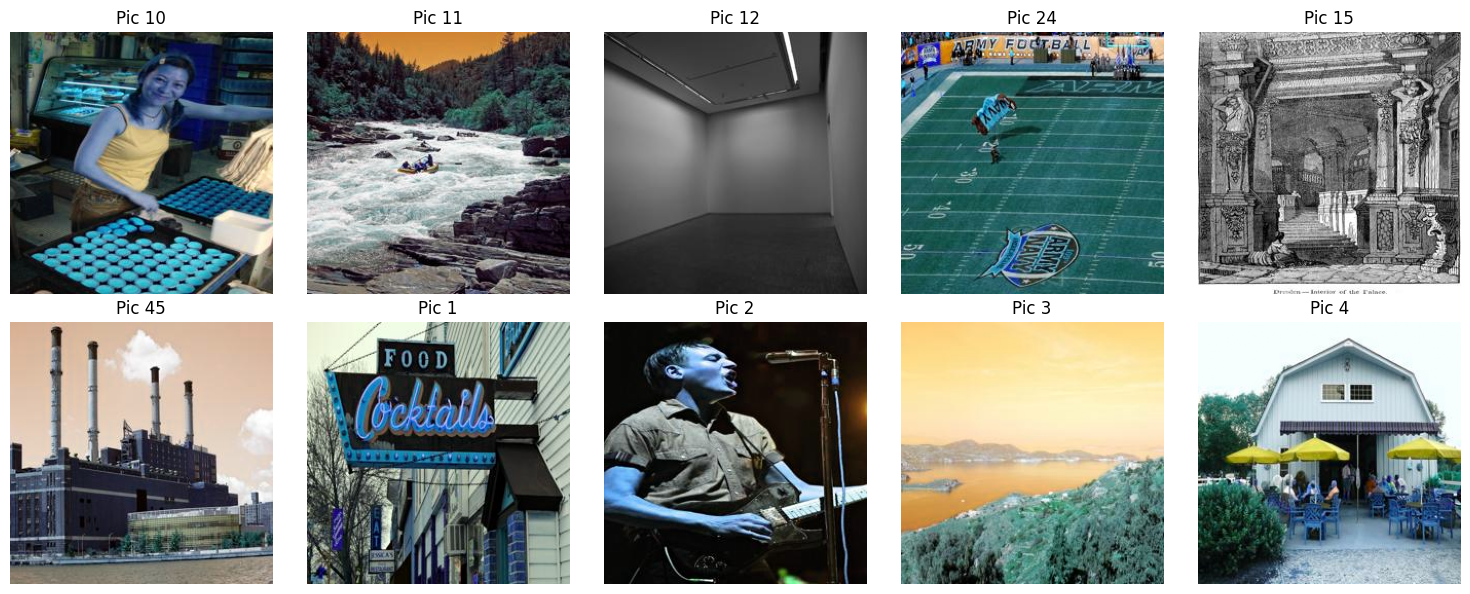

In [16]:
visualize_pic(train_data, [10, 11, 12, 24, 15, 45, 1, 2, 3,4 ])

Напишем свой класс датасета, создающий случайный поворот и смещение

In [17]:
class RotatedShiftedDataset(Dataset):
    def __init__(self, dataset, angle=(-15, 15), shift_range=(-1, 1)):
        self.dataset = dataset
        self.angle = angle
        self.shift_range = shift_range

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        im, label = self.dataset[idx]
        
        im_np = im.numpy() 
        
        angle = np.random.uniform(*self.angle)
        rotated_im = np.stack([rotate(im_np[channel], angle, mode='wrap') for channel in range(im_np.shape[0])], axis=0)
        
        shift_vals = np.random.uniform(self.shift_range[0], self.shift_range[1], size=2)  # сдвиг по x и y
        shifted_im = np.stack([shift(rotated_im[channel], shift_vals, mode='wrap') for channel in range(im_np.shape[0])], axis=0)

        shifted_im_tensor = torch.from_numpy(shifted_im)
        
        return shifted_im_tensor, label

In [18]:
from scipy.ndimage import rotate, shift, zoom

class RotatedShiftedDataset(Dataset):
    def __init__(self, dataset, angle=(-15, 15), shift_range=(-5, 5), target_size=(3, 256, 256)):
        self.dataset = dataset
        self.angle = angle
        self.shift_range = shift_range
        self.target_size = target_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        im, label = self.dataset[idx]
        
        im_np = im.numpy() 
        
        angle = np.random.uniform(*self.angle)
        rotated_im = np.stack([rotate(im_np[channel], angle, mode='wrap') for channel in range(im_np.shape[0])], axis=0)
        
        shift_vals = np.random.uniform(self.shift_range[0], self.shift_range[1], size=2)  # сдвиг по x и y
        shifted_im = np.stack([shift(rotated_im[channel], shift_vals, mode='wrap') for channel in range(im_np.shape[0])], axis=0)

        resized_im = np.clip(shifted_im, -1, 1)  # Убедимся, что значения в диапазоне [0, 1]
        resized_im = zoom(resized_im, (1, self.target_size[1] / shifted_im.shape[1], self.target_size[2] / shifted_im.shape[2]), order=1)

        resized_im_tensor = torch.from_numpy(resized_im)
        
        return resized_im_tensor, label


In [19]:
import torch
import torchvision.transforms as T
import random
from torch.utils.data import Dataset

class RotatedShiftedDataset(Dataset):
    def __init__(self, dataset, angle=(-15, 15), shift_range=(-5, 5), target_size=(3, 256, 256)):
        self.dataset = dataset
        self.angle = angle
        self.shift_range = shift_range
        self.target_size = target_size
        self.resize = T.Resize(self.target_size[1:])

    def __len__(self):
        return len(self.dataset)

    def random_rotate(self, im):
        angle = random.uniform(*self.angle)
        return T.functional.rotate(im, angle)

    def random_shift(self, im):
        max_dx = self.shift_range[1] - self.shift_range[0]
        max_dy = self.shift_range[1] - self.shift_range[0]
        dx = random.uniform(-max_dx, max_dx)
        dy = random.uniform(-max_dy, max_dy)
        return T.functional.affine(im, angle=0, translate=(dx, dy), scale=1, shear=0)

    def __getitem__(self, idx):
        im, label = self.dataset[idx]

        im = self.random_rotate(im)

        im = self.random_shift(im)

        im = self.resize(im)

        return im, label


In [20]:
rotated_shifted_dataset = RotatedShiftedDataset(train_data, angle=(-15, 15))
rotated_shifted_loader = DataLoader(rotated_shifted_dataset, batch_size=32, shuffle=True)

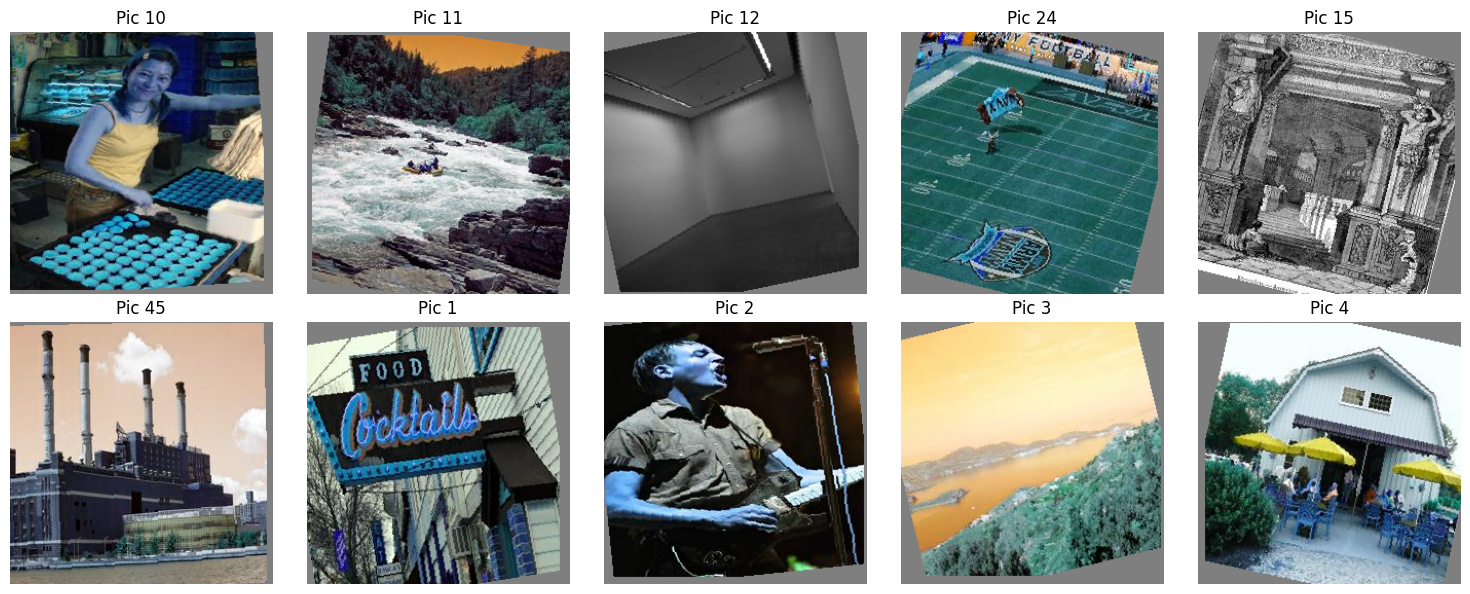

In [21]:
visualize_pic(rotated_shifted_dataset, [10, 11, 12, 24, 15, 45, 1, 2, 3,4 ])

Как видим, всё правильно - картинки повернулись и сдвинулись

Попробуем протестировать ту же Baseline_CNN в пределах 4 эпох и посмотрим на результаты.

In [22]:
rotated_shifted_dataset[9][0].shape

torch.Size([3, 256, 256])

In [28]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_2')

In [29]:
model_2 = Baseline_CNN()

model_2.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [30]:
train_model(model_2, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=4, writer=writer)

Пакеты: 100%|██████████| 10264/10264 [27:24<00:00,  6.24it/s]


Epoch [1/4], Loss: 0.3346, Accuracy: 0.8620, Val Loss: 0.2762, Val Accuracy: 0.8901
Validation accuracy improved from 0.0000 to 0.8901. Saving model...


Пакеты: 100%|██████████| 10264/10264 [24:18<00:00,  7.04it/s]


Epoch [2/4], Loss: 0.2806, Accuracy: 0.8899, Val Loss: 0.2616, Val Accuracy: 0.8964
Validation accuracy improved from 0.8901 to 0.8964. Saving model...


Пакеты: 100%|██████████| 10264/10264 [24:24<00:00,  7.01it/s]


Epoch [3/4], Loss: 0.2693, Accuracy: 0.8948, Val Loss: 0.2537, Val Accuracy: 0.9010
Validation accuracy improved from 0.8964 to 0.9010. Saving model...


Пакеты: 100%|██████████| 10264/10264 [24:30<00:00,  6.98it/s]


Epoch [4/4], Loss: 0.2644, Accuracy: 0.8978, Val Loss: 0.2473, Val Accuracy: 0.9066
Validation accuracy improved from 0.9010 to 0.9066. Saving model...


### Результаты 2 эксперимента  
![Alt text](images/exp2_acc.png)

Принципиально ничего не поменялось, в перспективе возможно, что переобучение будет достигаться дольше.

### Попробуем изменить нейросеть

Эксперимент 3  
Здесь увеличим количество свёрточных и линейных слоёв.

In [20]:
class CNN_model_3(nn.Module):
    def __init__(self):
        super(CNN_model_3, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Запустим обучение на 10 эпох и посмотрим, что получится

In [21]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_3')

In [22]:
model_3 = CNN_model_3()

model_3.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

Обучим также на аугментированном датасете.

In [23]:
train_model(model_3, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_3.pth')

Пакеты: 100%|██████████| 10264/10264 [40:02<00:00,  4.27it/s]


Epoch [1/20], Loss: 0.3429, Accuracy: 0.8587, Val Loss: 0.2789, Val Accuracy: 0.8873
Validation accuracy improved from 0.0000 to 0.8873. Saving model...


Пакеты: 100%|██████████| 10264/10264 [39:26<00:00,  4.34it/s]


Epoch [2/20], Loss: 0.2959, Accuracy: 0.8833, Val Loss: 0.2787, Val Accuracy: 0.8923
Validation accuracy improved from 0.8873 to 0.8923. Saving model...


Пакеты: 100%|██████████| 10264/10264 [39:15<00:00,  4.36it/s]


Epoch [3/20], Loss: 0.2848, Accuracy: 0.8886, Val Loss: 0.2576, Val Accuracy: 0.8996
Validation accuracy improved from 0.8923 to 0.8996. Saving model...


Пакеты: 100%|██████████| 10264/10264 [39:14<00:00,  4.36it/s]


Epoch [4/20], Loss: 0.2788, Accuracy: 0.8921, Val Loss: 0.2445, Val Accuracy: 0.9058
Validation accuracy improved from 0.8996 to 0.9058. Saving model...


Пакеты: 100%|██████████| 10264/10264 [39:17<00:00,  4.35it/s]


Epoch [5/20], Loss: 0.2765, Accuracy: 0.8933, Val Loss: 0.2490, Val Accuracy: 0.9036


Пакеты: 100%|██████████| 10264/10264 [39:16<00:00,  4.35it/s]


Epoch [6/20], Loss: 0.2745, Accuracy: 0.8939, Val Loss: 0.2696, Val Accuracy: 0.8965


Пакеты: 100%|██████████| 10264/10264 [39:20<00:00,  4.35it/s]


Epoch [7/20], Loss: 0.2745, Accuracy: 0.8941, Val Loss: 0.2554, Val Accuracy: 0.9004


Пакеты: 100%|██████████| 10264/10264 [39:20<00:00,  4.35it/s]


Epoch [8/20], Loss: 0.2716, Accuracy: 0.8955, Val Loss: 0.2529, Val Accuracy: 0.9051


Пакеты: 100%|██████████| 10264/10264 [39:22<00:00,  4.34it/s]


Epoch [9/20], Loss: 0.2723, Accuracy: 0.8955, Val Loss: 0.2519, Val Accuracy: 0.9026


Пакеты: 100%|██████████| 10264/10264 [39:23<00:00,  4.34it/s]


Epoch [10/20], Loss: 0.2735, Accuracy: 0.8955, Val Loss: 0.2518, Val Accuracy: 0.9021


Пакеты: 100%|██████████| 10264/10264 [39:25<00:00,  4.34it/s]


Epoch [11/20], Loss: 0.2730, Accuracy: 0.8952, Val Loss: 0.2555, Val Accuracy: 0.9040


Пакеты: 100%|██████████| 10264/10264 [39:15<00:00,  4.36it/s]


Epoch [12/20], Loss: 0.2781, Accuracy: 0.8942, Val Loss: 0.2641, Val Accuracy: 0.8957


Пакеты: 100%|██████████| 10264/10264 [39:16<00:00,  4.36it/s]


Epoch [13/20], Loss: 0.2747, Accuracy: 0.8952, Val Loss: 0.2530, Val Accuracy: 0.9051


Пакеты: 100%|██████████| 10264/10264 [39:17<00:00,  4.35it/s]


Epoch [14/20], Loss: 0.2752, Accuracy: 0.8953, Val Loss: 0.2516, Val Accuracy: 0.9042


Пакеты: 100%|██████████| 10264/10264 [39:17<00:00,  4.35it/s]


Epoch [15/20], Loss: 0.2792, Accuracy: 0.8938, Val Loss: 0.2861, Val Accuracy: 0.8934


Пакеты: 100%|██████████| 10264/10264 [39:22<00:00,  4.34it/s]


Epoch [16/20], Loss: 0.2743, Accuracy: 0.8954, Val Loss: 0.2473, Val Accuracy: 0.9067
Validation accuracy improved from 0.9058 to 0.9067. Saving model...


Пакеты: 100%|██████████| 10264/10264 [39:20<00:00,  4.35it/s]


Epoch [17/20], Loss: 0.2740, Accuracy: 0.8956, Val Loss: 0.2589, Val Accuracy: 0.9050


Пакеты:  48%|████▊     | 4884/10264 [18:41<20:35,  4.35it/s]


KeyboardInterrupt: 

### Результаты CNN_model_3

Результаты неудовлетворительные, модель работает хуже и дольше, чем baseline

Попробуем в таком случае не усложнить модель, а наоборот упростить

In [21]:
class CNN_model_4(nn.Module):
    def __init__(self):
        super(CNN_model_4, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Полносвязный слой
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 32 * 32, 128),  # Размер для изображений 256x256
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Развернуть тензор
        x = self.fc_layers(x)
        return x


Здесь мы уменьшили полносвязный скрытый слой и сделали менее агрессивный dropout

In [22]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_4')

In [23]:
model_4 = CNN_model_4()

model_4.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.001)

In [24]:
train_model(model_4, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_5.pth')

Пакеты: 100%|██████████| 10264/10264 [21:49<00:00,  7.84it/s]


Epoch [1/20], Loss: 0.3301, Accuracy: 0.8640, Val Loss: 0.2761, Val Accuracy: 0.8890
Validation accuracy improved from 0.0000 to 0.8890. Saving model...


Пакеты: 100%|██████████| 10264/10264 [21:34<00:00,  7.93it/s]


Epoch [2/20], Loss: 0.2784, Accuracy: 0.8908, Val Loss: 0.2757, Val Accuracy: 0.8894
Validation accuracy improved from 0.8890 to 0.8894. Saving model...


Пакеты: 100%|██████████| 10264/10264 [21:40<00:00,  7.89it/s]


Epoch [3/20], Loss: 0.2662, Accuracy: 0.8966, Val Loss: 0.2440, Val Accuracy: 0.9051
Validation accuracy improved from 0.8894 to 0.9051. Saving model...


Пакеты: 100%|██████████| 10264/10264 [21:42<00:00,  7.88it/s]


Epoch [4/20], Loss: 0.2581, Accuracy: 0.9001, Val Loss: 0.2718, Val Accuracy: 0.8939


Пакеты:  44%|████▎     | 4483/10264 [09:26<12:10,  7.91it/s]


KeyboardInterrupt: 

Попробуем модель ещё проще

In [20]:
class CNN_model_5(nn.Module):
    def __init__(self):
        super(CNN_model_5, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 64 * 64, 64),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x

In [21]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_5')

In [22]:
model_5 = CNN_model_5()

model_5.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_5.parameters(), lr=0.001)

In [23]:
train_model(model_5, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_5.pth')

Пакеты: 100%|██████████| 10264/10264 [19:38<00:00,  8.71it/s]


Epoch [1/20], Loss: 0.3593, Accuracy: 0.8520, Val Loss: 0.2918, Val Accuracy: 0.8831
Validation accuracy improved from 0.0000 to 0.8831. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:30<00:00,  8.77it/s]


Epoch [2/20], Loss: 0.3033, Accuracy: 0.8812, Val Loss: 0.2688, Val Accuracy: 0.8949
Validation accuracy improved from 0.8831 to 0.8949. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:25<00:00,  8.81it/s]


Epoch [3/20], Loss: 0.2896, Accuracy: 0.8867, Val Loss: 0.2936, Val Accuracy: 0.8826


Пакеты: 100%|██████████| 10264/10264 [19:24<00:00,  8.81it/s]


Epoch [4/20], Loss: 0.2805, Accuracy: 0.8904, Val Loss: 0.2539, Val Accuracy: 0.9035
Validation accuracy improved from 0.8949 to 0.9035. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:22<00:00,  8.83it/s]


Epoch [5/20], Loss: 0.2736, Accuracy: 0.8942, Val Loss: 0.2602, Val Accuracy: 0.9005


Пакеты: 100%|██████████| 10264/10264 [19:26<00:00,  8.80it/s]


Epoch [6/20], Loss: 0.2711, Accuracy: 0.8954, Val Loss: 0.2584, Val Accuracy: 0.9017


Пакеты: 100%|██████████| 10264/10264 [19:27<00:00,  8.79it/s]


Epoch [7/20], Loss: 0.2677, Accuracy: 0.8969, Val Loss: 0.2523, Val Accuracy: 0.9040
Validation accuracy improved from 0.9035 to 0.9040. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:25<00:00,  8.81it/s]


Epoch [8/20], Loss: 0.2653, Accuracy: 0.8980, Val Loss: 0.2482, Val Accuracy: 0.9036


Пакеты: 100%|██████████| 10264/10264 [19:26<00:00,  8.80it/s]


Epoch [9/20], Loss: 0.2634, Accuracy: 0.8988, Val Loss: 0.2450, Val Accuracy: 0.9067
Validation accuracy improved from 0.9040 to 0.9067. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:27<00:00,  8.79it/s]


Epoch [10/20], Loss: 0.2614, Accuracy: 0.8996, Val Loss: 0.2486, Val Accuracy: 0.9068
Validation accuracy improved from 0.9067 to 0.9068. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:31<00:00,  8.76it/s]


Epoch [11/20], Loss: 0.2620, Accuracy: 0.9002, Val Loss: 0.2507, Val Accuracy: 0.9055


Пакеты: 100%|██████████| 10264/10264 [19:29<00:00,  8.77it/s]


Epoch [12/20], Loss: 0.2601, Accuracy: 0.9010, Val Loss: 0.2404, Val Accuracy: 0.9093
Validation accuracy improved from 0.9068 to 0.9093. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:28<00:00,  8.78it/s]


Epoch [13/20], Loss: 0.2583, Accuracy: 0.9015, Val Loss: 0.2395, Val Accuracy: 0.9102
Validation accuracy improved from 0.9093 to 0.9102. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:28<00:00,  8.79it/s]


Epoch [14/20], Loss: 0.2570, Accuracy: 0.9020, Val Loss: 0.2387, Val Accuracy: 0.9089


Пакеты: 100%|██████████| 10264/10264 [19:30<00:00,  8.77it/s]


Epoch [15/20], Loss: 0.2557, Accuracy: 0.9019, Val Loss: 0.2416, Val Accuracy: 0.9125
Validation accuracy improved from 0.9102 to 0.9125. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:27<00:00,  8.79it/s]


Epoch [16/20], Loss: 0.2555, Accuracy: 0.9030, Val Loss: 0.2378, Val Accuracy: 0.9102


Пакеты: 100%|██████████| 10264/10264 [19:27<00:00,  8.79it/s]


Epoch [17/20], Loss: 0.2543, Accuracy: 0.9030, Val Loss: 0.2502, Val Accuracy: 0.9112


Пакеты: 100%|██████████| 10264/10264 [19:28<00:00,  8.79it/s]


Epoch [18/20], Loss: 0.2546, Accuracy: 0.9027, Val Loss: 0.2447, Val Accuracy: 0.9074


Пакеты: 100%|██████████| 10264/10264 [19:29<00:00,  8.78it/s]


Epoch [19/20], Loss: 0.2543, Accuracy: 0.9033, Val Loss: 0.2431, Val Accuracy: 0.9094


Пакеты: 100%|██████████| 10264/10264 [19:33<00:00,  8.74it/s]


Epoch [20/20], Loss: 0.2535, Accuracy: 0.9035, Val Loss: 0.2408, Val Accuracy: 0.9103


### Результаты 5-го эксперимента  
![Alt text](images/exp5_acc.png)   
![Alt text](images/exp5_loss.png)

Такая модель показала наибольшее качество, и меньше переобучилась

Будем двигаться в том же направлении - в сторону упрощения архитектуры

### Эксперимент 6

In [25]:
import torch.nn as nn

class CNN_model_6(nn.Module):
    def __init__(self):
        super(CNN_model_6, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 15 * 15, 64), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [26]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_6')

In [27]:
model_6 = CNN_model_6()

model_6.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_6.parameters(), lr=0.001)

In [28]:
train_model(model_6, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_6.pth')

Пакеты: 100%|██████████| 10264/10264 [17:27<00:00,  9.80it/s]


Epoch [1/20], Loss: 0.3471, Accuracy: 0.8534, Val Loss: 0.2888, Val Accuracy: 0.8840
Validation accuracy improved from 0.0000 to 0.8840. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:14<00:00,  9.92it/s]


Epoch [2/20], Loss: 0.2959, Accuracy: 0.8810, Val Loss: 0.2716, Val Accuracy: 0.8906
Validation accuracy improved from 0.8840 to 0.8906. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:04<00:00, 10.02it/s]


Epoch [3/20], Loss: 0.2809, Accuracy: 0.8883, Val Loss: 0.2657, Val Accuracy: 0.8942
Validation accuracy improved from 0.8906 to 0.8942. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:04<00:00, 10.02it/s]


Epoch [4/20], Loss: 0.2726, Accuracy: 0.8920, Val Loss: 0.2594, Val Accuracy: 0.8983
Validation accuracy improved from 0.8942 to 0.8983. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:10<00:00,  9.96it/s]


Epoch [5/20], Loss: 0.2656, Accuracy: 0.8963, Val Loss: 0.2682, Val Accuracy: 0.8928


Пакеты: 100%|██████████| 10264/10264 [17:22<00:00,  9.84it/s]


Epoch [6/20], Loss: 0.2620, Accuracy: 0.8977, Val Loss: 0.2528, Val Accuracy: 0.8994
Validation accuracy improved from 0.8983 to 0.8994. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:58<00:00,  9.51it/s]


Epoch [7/20], Loss: 0.2585, Accuracy: 0.8996, Val Loss: 0.2583, Val Accuracy: 0.9013
Validation accuracy improved from 0.8994 to 0.9013. Saving model...


Пакеты: 100%|██████████| 10264/10264 [19:24<00:00,  8.81it/s]


Epoch [8/20], Loss: 0.2561, Accuracy: 0.9008, Val Loss: 0.2640, Val Accuracy: 0.8972


Пакеты:   7%|▋         | 728/10264 [01:20<17:38,  9.01it/s]


KeyboardInterrupt: 

### Остальные эксперименты  
В этот момент я заметил, что всё это время логировал в Tensorboard "cats_vs_dogs_experiment" (взял код с семинара) здесь кошками и "не пахнет" но для единообразия решил оставить это название "как есть".

In [39]:
class CNN_model_7(nn.Module):
    def __init__(self):
        super(CNN_model_7, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(63504, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [40]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_7')

In [41]:
model_7 = CNN_model_7()

model_7.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_7.parameters(), lr=0.001)

In [42]:
train_model(model_7, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_7.pth')

Пакеты: 100%|██████████| 10264/10264 [17:16<00:00,  9.90it/s]


Epoch [1/20], Loss: 0.4573, Accuracy: 0.7946, Val Loss: 0.4224, Val Accuracy: 0.8213
Validation accuracy improved from 0.0000 to 0.8213. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:21<00:00, 10.46it/s]


Epoch [2/20], Loss: 0.4185, Accuracy: 0.8193, Val Loss: 0.3503, Val Accuracy: 0.8516
Validation accuracy improved from 0.8213 to 0.8516. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:29<00:00, 10.37it/s]


Epoch [3/20], Loss: 0.4067, Accuracy: 0.8274, Val Loss: 0.3488, Val Accuracy: 0.8528
Validation accuracy improved from 0.8516 to 0.8528. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:26<00:00, 10.40it/s]


Epoch [4/20], Loss: 0.3980, Accuracy: 0.8321, Val Loss: 0.3516, Val Accuracy: 0.8451


Пакеты:  17%|█▋        | 1741/10264 [02:48<13:42, 10.36it/s]


KeyboardInterrupt: 

Здесь пытаюсь эксперементировать с другими трансформациями, получилось не очень

In [23]:
transforms_2 = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


In [24]:
full_data = ImageFolder(data_dir, transform=transforms_2)

train_size = int(0.8 * len(full_data))
val_size = int(0.1 * len(full_data))
test_size = len(full_data) - train_size - val_size

train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])

In [25]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [26]:
class CNN_model_5_8(nn.Module):
    def __init__(self):
        super(CNN_model_5_8, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(8192, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x

In [35]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_8')

In [27]:
model_8 = CNN_model_5_8()

model_8.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_8.parameters(), lr=0.001)

In [37]:
train_model(model_8, train_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_8.pth')

Пакеты: 100%|██████████| 10264/10264 [45:50<00:00,  3.73it/s]


Epoch [1/20], Loss: 0.3906, Accuracy: 0.8314, Val Loss: 0.3506, Val Accuracy: 0.8495
Validation accuracy improved from 0.0000 to 0.8495. Saving model...


Пакеты: 100%|██████████| 10264/10264 [42:29<00:00,  4.03it/s]


Epoch [2/20], Loss: 0.3291, Accuracy: 0.8648, Val Loss: 0.3041, Val Accuracy: 0.8767
Validation accuracy improved from 0.8495 to 0.8767. Saving model...


Пакеты: 100%|██████████| 10264/10264 [42:46<00:00,  4.00it/s]


Epoch [3/20], Loss: 0.3116, Accuracy: 0.8741, Val Loss: 0.2856, Val Accuracy: 0.8852
Validation accuracy improved from 0.8767 to 0.8852. Saving model...


Пакеты: 100%|██████████| 10264/10264 [42:39<00:00,  4.01it/s]


Epoch [4/20], Loss: 0.3037, Accuracy: 0.8786, Val Loss: 0.2882, Val Accuracy: 0.8872
Validation accuracy improved from 0.8852 to 0.8872. Saving model...


Пакеты:   9%|▊         | 898/10264 [03:44<39:04,  4.00it/s]


KeyboardInterrupt: 

In [28]:
half_size = len(rotated_shifted_dataset) // 2
dataset_size = len(rotated_shifted_dataset)

In [29]:
rotated_shifted_dataset_1, rotated_shifted_dataset_2 = random_split(rotated_shifted_dataset, [half_size, dataset_size - half_size])

In [30]:
rotated_shifted_loader = DataLoader(rotated_shifted_dataset_1, batch_size=32, shuffle=True)

In [28]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_8.1')
criterion = nn.BCELoss()
optimizer = optim.Adam(model_8.parameters(), lr=0.0001)

In [29]:
train_model(model_8, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_8.1.pth')

Пакеты: 100%|██████████| 10264/10264 [19:32<00:00,  8.75it/s]


Epoch [1/20], Loss: 0.3957, Accuracy: 0.8296, Val Loss: 0.3249, Val Accuracy: 0.8640
Validation accuracy improved from 0.0000 to 0.8640. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:10<00:00,  9.96it/s]


Epoch [2/20], Loss: 0.3338, Accuracy: 0.8638, Val Loss: 0.3088, Val Accuracy: 0.8751
Validation accuracy improved from 0.8640 to 0.8751. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:08<00:00,  9.98it/s]


Epoch [3/20], Loss: 0.3168, Accuracy: 0.8729, Val Loss: 0.2821, Val Accuracy: 0.8862
Validation accuracy improved from 0.8751 to 0.8862. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:06<00:00, 10.00it/s]


Epoch [4/20], Loss: 0.3054, Accuracy: 0.8784, Val Loss: 0.2748, Val Accuracy: 0.8911
Validation accuracy improved from 0.8862 to 0.8911. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:08<00:00,  9.98it/s]


Epoch [5/20], Loss: 0.2978, Accuracy: 0.8817, Val Loss: 0.2719, Val Accuracy: 0.8894


Пакеты: 100%|██████████| 10264/10264 [17:07<00:00,  9.99it/s]


Epoch [6/20], Loss: 0.2916, Accuracy: 0.8848, Val Loss: 0.2633, Val Accuracy: 0.8954
Validation accuracy improved from 0.8911 to 0.8954. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:21<00:00,  9.85it/s]


Epoch [7/20], Loss: 0.2875, Accuracy: 0.8870, Val Loss: 0.2702, Val Accuracy: 0.8930


Пакеты: 100%|██████████| 10264/10264 [17:28<00:00,  9.79it/s]


Epoch [8/20], Loss: 0.2823, Accuracy: 0.8888, Val Loss: 0.2601, Val Accuracy: 0.8948


Пакеты: 100%|██████████| 10264/10264 [17:31<00:00,  9.76it/s]


Epoch [9/20], Loss: 0.2789, Accuracy: 0.8908, Val Loss: 0.2581, Val Accuracy: 0.8954


Пакеты: 100%|██████████| 10264/10264 [17:23<00:00,  9.84it/s]


Epoch [10/20], Loss: 0.2769, Accuracy: 0.8919, Val Loss: 0.2527, Val Accuracy: 0.8987
Validation accuracy improved from 0.8954 to 0.8987. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:25<00:00,  9.81it/s]


Epoch [11/20], Loss: 0.2739, Accuracy: 0.8931, Val Loss: 0.2480, Val Accuracy: 0.9018
Validation accuracy improved from 0.8987 to 0.9018. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:29<00:00,  9.78it/s]


Epoch [12/20], Loss: 0.2713, Accuracy: 0.8940, Val Loss: 0.2459, Val Accuracy: 0.9036
Validation accuracy improved from 0.9018 to 0.9036. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:34<00:00,  9.74it/s]


Epoch [13/20], Loss: 0.2690, Accuracy: 0.8953, Val Loss: 0.2450, Val Accuracy: 0.9052
Validation accuracy improved from 0.9036 to 0.9052. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:23<00:00,  9.84it/s]


Epoch [14/20], Loss: 0.2681, Accuracy: 0.8964, Val Loss: 0.2439, Val Accuracy: 0.9037


Пакеты: 100%|██████████| 10264/10264 [17:21<00:00,  9.86it/s]


Epoch [15/20], Loss: 0.2652, Accuracy: 0.8967, Val Loss: 0.2418, Val Accuracy: 0.9060
Validation accuracy improved from 0.9052 to 0.9060. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:19<00:00,  9.88it/s]


Epoch [16/20], Loss: 0.2644, Accuracy: 0.8973, Val Loss: 0.2415, Val Accuracy: 0.9069
Validation accuracy improved from 0.9060 to 0.9069. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:57<00:00, 10.09it/s]


Epoch [17/20], Loss: 0.2622, Accuracy: 0.8989, Val Loss: 0.2451, Val Accuracy: 0.9044


Пакеты: 100%|██████████| 10264/10264 [16:54<00:00, 10.11it/s]


Epoch [18/20], Loss: 0.2609, Accuracy: 0.8988, Val Loss: 0.2434, Val Accuracy: 0.9042


Пакеты:  53%|█████▎    | 5403/10264 [08:55<08:01, 10.10it/s]


KeyboardInterrupt: 

In [23]:
class CNN_model_5_9(nn.Module):
    def __init__(self):
        super(CNN_model_5_9, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [24]:
model_9 = CNN_model_5_9()

model_9.to(device)

CNN_model_5_9(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [25]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_9')
criterion = nn.BCELoss()
optimizer = optim.Adam(model_9.parameters(), lr=0.001)

In [26]:
train_model(model_9, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_9.pth')

Пакеты: 100%|██████████| 10264/10264 [19:38<00:00,  8.71it/s]


Epoch [1/20], Loss: 0.3583, Accuracy: 0.8540, Val Loss: 0.2995, Val Accuracy: 0.8785
Validation accuracy improved from 0.0000 to 0.8785. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:08<00:00,  9.98it/s]


Epoch [2/20], Loss: 0.3109, Accuracy: 0.8792, Val Loss: 0.2708, Val Accuracy: 0.8922
Validation accuracy improved from 0.8785 to 0.8922. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:06<00:00, 10.00it/s]


Epoch [3/20], Loss: 0.2997, Accuracy: 0.8849, Val Loss: 0.2636, Val Accuracy: 0.8976
Validation accuracy improved from 0.8922 to 0.8976. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:17<00:00,  9.89it/s]


Epoch [4/20], Loss: 0.2926, Accuracy: 0.8881, Val Loss: 0.2537, Val Accuracy: 0.9007
Validation accuracy improved from 0.8976 to 0.9007. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:18<00:00,  9.89it/s]


Epoch [5/20], Loss: 0.2915, Accuracy: 0.8904, Val Loss: 0.2582, Val Accuracy: 0.9002


Пакеты: 100%|██████████| 10264/10264 [17:03<00:00, 10.02it/s]


Epoch [6/20], Loss: 0.2891, Accuracy: 0.8919, Val Loss: 0.2579, Val Accuracy: 0.8975


Пакеты: 100%|██████████| 10264/10264 [17:10<00:00,  9.96it/s]


Epoch [7/20], Loss: 0.2873, Accuracy: 0.8921, Val Loss: 0.2555, Val Accuracy: 0.9000


Пакеты: 100%|██████████| 10264/10264 [17:51<00:00,  9.58it/s]


Epoch [8/20], Loss: 0.2867, Accuracy: 0.8925, Val Loss: 0.2670, Val Accuracy: 0.8968


Пакеты: 100%|██████████| 10264/10264 [17:41<00:00,  9.67it/s]


Epoch [9/20], Loss: 0.2870, Accuracy: 0.8930, Val Loss: 0.2516, Val Accuracy: 0.9022
Validation accuracy improved from 0.9007 to 0.9022. Saving model...


Пакеты: 100%|██████████| 10264/10264 [18:11<00:00,  9.40it/s]


Epoch [10/20], Loss: 0.2858, Accuracy: 0.8932, Val Loss: 0.2513, Val Accuracy: 0.9033
Validation accuracy improved from 0.9022 to 0.9033. Saving model...


Пакеты: 100%|██████████| 10264/10264 [18:03<00:00,  9.47it/s]


Epoch [11/20], Loss: 0.2858, Accuracy: 0.8933, Val Loss: 0.2469, Val Accuracy: 0.9061
Validation accuracy improved from 0.9033 to 0.9061. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:53<00:00,  9.56it/s]


Epoch [12/20], Loss: 0.2872, Accuracy: 0.8938, Val Loss: 0.2476, Val Accuracy: 0.9066
Validation accuracy improved from 0.9061 to 0.9066. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:15<00:00,  9.92it/s]


Epoch [13/20], Loss: 0.2865, Accuracy: 0.8940, Val Loss: 0.2559, Val Accuracy: 0.9018


Пакеты: 100%|██████████| 10264/10264 [17:10<00:00,  9.96it/s]


Epoch [14/20], Loss: 0.2895, Accuracy: 0.8940, Val Loss: 0.2572, Val Accuracy: 0.9025


Пакеты: 100%|██████████| 10264/10264 [17:09<00:00,  9.97it/s]


Epoch [15/20], Loss: 0.2868, Accuracy: 0.8940, Val Loss: 0.2801, Val Accuracy: 0.9026


Пакеты: 100%|██████████| 10264/10264 [17:15<00:00,  9.91it/s]


Epoch [16/20], Loss: 0.2934, Accuracy: 0.8931, Val Loss: 0.2537, Val Accuracy: 0.9030


Пакеты: 100%|██████████| 10264/10264 [17:12<00:00,  9.94it/s]


Epoch [17/20], Loss: 0.2920, Accuracy: 0.8927, Val Loss: 0.2714, Val Accuracy: 0.8962


Пакеты: 100%|██████████| 10264/10264 [17:09<00:00,  9.97it/s]


Epoch [18/20], Loss: 0.2951, Accuracy: 0.8923, Val Loss: 0.2704, Val Accuracy: 0.9031


Пакеты: 100%|██████████| 10264/10264 [17:09<00:00,  9.97it/s]


Epoch [19/20], Loss: 0.2953, Accuracy: 0.8925, Val Loss: 0.2578, Val Accuracy: 0.9064


Пакеты: 100%|██████████| 10264/10264 [17:14<00:00,  9.92it/s]


Epoch [20/20], Loss: 0.2973, Accuracy: 0.8923, Val Loss: 0.2613, Val Accuracy: 0.9050


In [39]:
class CNN_model_5_10(nn.Module):
    def __init__(self):
        super(CNN_model_5_10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 1024), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x

In [32]:
model_10 = CNN_model_5_10()

model_10.to(device)

CNN_model_5_10(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1,

In [33]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_10')
criterion = nn.BCELoss()
optimizer = optim.Adam(model_10.parameters(), lr=0.001)

In [34]:
train_model(model_10, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_10.pth')

Пакеты: 100%|██████████| 10264/10264 [17:18<00:00,  9.89it/s]


Epoch [1/20], Loss: 0.3205, Accuracy: 0.8690, Val Loss: 0.2538, Val Accuracy: 0.8980
Validation accuracy improved from 0.0000 to 0.8980. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:48<00:00, 10.18it/s]


Epoch [2/20], Loss: 0.2692, Accuracy: 0.8940, Val Loss: 0.2510, Val Accuracy: 0.8988
Validation accuracy improved from 0.8980 to 0.8988. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:43<00:00, 10.22it/s]


Epoch [3/20], Loss: 0.2553, Accuracy: 0.9016, Val Loss: 0.2511, Val Accuracy: 0.9051
Validation accuracy improved from 0.8988 to 0.9051. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:33<00:00, 10.33it/s]


Epoch [4/20], Loss: 0.2457, Accuracy: 0.9053, Val Loss: 0.2492, Val Accuracy: 0.9084
Validation accuracy improved from 0.9051 to 0.9084. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:43<00:00, 10.23it/s]


Epoch [5/20], Loss: 0.2398, Accuracy: 0.9088, Val Loss: 0.2268, Val Accuracy: 0.9177
Validation accuracy improved from 0.9084 to 0.9177. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:35<00:00, 10.31it/s]


Epoch [6/20], Loss: 0.2349, Accuracy: 0.9107, Val Loss: 0.2188, Val Accuracy: 0.9165


Пакеты: 100%|██████████| 10264/10264 [16:45<00:00, 10.21it/s]


Epoch [7/20], Loss: 0.2314, Accuracy: 0.9127, Val Loss: 0.2206, Val Accuracy: 0.9202
Validation accuracy improved from 0.9177 to 0.9202. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:45<00:00, 10.21it/s]


Epoch [8/20], Loss: 0.2289, Accuracy: 0.9137, Val Loss: 0.2291, Val Accuracy: 0.9155


Пакеты: 100%|██████████| 10264/10264 [16:45<00:00, 10.21it/s]


Epoch [9/20], Loss: 0.2314, Accuracy: 0.9148, Val Loss: 0.2199, Val Accuracy: 0.9159


Пакеты: 100%|██████████| 10264/10264 [16:37<00:00, 10.29it/s]


Epoch [10/20], Loss: 0.2255, Accuracy: 0.9158, Val Loss: 0.2550, Val Accuracy: 0.9069


Пакеты: 100%|██████████| 10264/10264 [16:36<00:00, 10.30it/s]


Epoch [11/20], Loss: 0.2234, Accuracy: 0.9174, Val Loss: 0.2069, Val Accuracy: 0.9221
Validation accuracy improved from 0.9202 to 0.9221. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:49<00:00, 10.17it/s]


Epoch [12/20], Loss: 0.2217, Accuracy: 0.9180, Val Loss: 0.2195, Val Accuracy: 0.9202


Пакеты: 100%|██████████| 10264/10264 [16:41<00:00, 10.25it/s]


Epoch [13/20], Loss: 0.2226, Accuracy: 0.9185, Val Loss: 0.2521, Val Accuracy: 0.9159


Пакеты: 100%|██████████| 10264/10264 [16:39<00:00, 10.27it/s]


Epoch [14/20], Loss: 0.2238, Accuracy: 0.9185, Val Loss: 0.2199, Val Accuracy: 0.9175


Пакеты: 100%|██████████| 10264/10264 [16:35<00:00, 10.31it/s]


Epoch [15/20], Loss: 0.2212, Accuracy: 0.9191, Val Loss: 0.2359, Val Accuracy: 0.9205


Пакеты: 100%|██████████| 10264/10264 [16:37<00:00, 10.29it/s]


Epoch [16/20], Loss: 0.2209, Accuracy: 0.9186, Val Loss: 0.2252, Val Accuracy: 0.9235
Validation accuracy improved from 0.9221 to 0.9235. Saving model...


Пакеты:  25%|██▌       | 2566/10264 [04:10<12:32, 10.23it/s]


KeyboardInterrupt: 

In [26]:
class CNN_model_11(nn.Module):
    def __init__(self):
        super(CNN_model_11, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 64), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [27]:
model_11 = CNN_model_11()

model_11.to(device)

CNN_model_11(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, in

In [28]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_11')
criterion = nn.BCELoss()
optimizer = optim.Adam(model_11.parameters(), lr=0.001)

In [29]:
train_model(model_11, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_11.pth')

Пакеты: 100%|██████████| 10264/10264 [19:30<00:00,  8.77it/s]


Epoch [1/20], Loss: 0.3279, Accuracy: 0.8653, Val Loss: 0.2689, Val Accuracy: 0.8920
Validation accuracy improved from 0.0000 to 0.8920. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:41<00:00, 10.25it/s]


Epoch [2/20], Loss: 0.2776, Accuracy: 0.8911, Val Loss: 0.2644, Val Accuracy: 0.8989
Validation accuracy improved from 0.8920 to 0.8989. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:42<00:00, 10.24it/s]


Epoch [3/20], Loss: 0.2632, Accuracy: 0.8980, Val Loss: 0.2613, Val Accuracy: 0.9058
Validation accuracy improved from 0.8989 to 0.9058. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:45<00:00, 10.20it/s]


Epoch [4/20], Loss: 0.2561, Accuracy: 0.9019, Val Loss: 0.2368, Val Accuracy: 0.9090
Validation accuracy improved from 0.9058 to 0.9090. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:48<00:00, 10.18it/s]


Epoch [5/20], Loss: 0.2505, Accuracy: 0.9036, Val Loss: 0.2441, Val Accuracy: 0.9048


Пакеты: 100%|██████████| 10264/10264 [16:43<00:00, 10.23it/s]


Epoch [6/20], Loss: 0.2463, Accuracy: 0.9059, Val Loss: 0.2355, Val Accuracy: 0.9139
Validation accuracy improved from 0.9090 to 0.9139. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:34<00:00, 10.32it/s]


Epoch [7/20], Loss: 0.2438, Accuracy: 0.9072, Val Loss: 0.2355, Val Accuracy: 0.9126


Пакеты: 100%|██████████| 10264/10264 [16:33<00:00, 10.33it/s]


Epoch [8/20], Loss: 0.2426, Accuracy: 0.9083, Val Loss: 0.2276, Val Accuracy: 0.9140
Validation accuracy improved from 0.9139 to 0.9140. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:48<00:00, 10.17it/s]


Epoch [9/20], Loss: 0.2414, Accuracy: 0.9084, Val Loss: 0.2382, Val Accuracy: 0.9139


Пакеты: 100%|██████████| 10264/10264 [16:34<00:00, 10.33it/s]


Epoch [10/20], Loss: 0.2385, Accuracy: 0.9098, Val Loss: 0.2387, Val Accuracy: 0.9049


Пакеты: 100%|██████████| 10264/10264 [17:07<00:00,  9.99it/s]


Epoch [11/20], Loss: 0.2420, Accuracy: 0.9103, Val Loss: 0.2322, Val Accuracy: 0.9101


Пакеты:  56%|█████▌    | 5728/10264 [09:25<07:27, 10.13it/s]


KeyboardInterrupt: 

In [34]:
class CNN_model_12(nn.Module):
    def __init__(self):
        super(CNN_model_12, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x

In [35]:
model_12 = CNN_model_12()

model_12.to(device)

CNN_model_12(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=64

In [36]:
writer = SummaryWriter('runs/cats_vs_dogs_experiment_12')
criterion = nn.BCELoss()
optimizer = optim.Adam(model_12.parameters(), lr=0.001)

In [37]:
train_model(model_12, rotated_shifted_loader, val_loader, criterion, optimizer, num_epochs=20, writer=writer, model_filename='cnn_best_checkpoint_12.pth')

Пакеты: 100%|██████████| 10264/10264 [16:44<00:00, 10.22it/s]


Epoch [1/20], Loss: 0.3333, Accuracy: 0.8632, Val Loss: 0.2782, Val Accuracy: 0.8881
Validation accuracy improved from 0.0000 to 0.8881. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:44<00:00, 10.22it/s]


Epoch [2/20], Loss: 0.2810, Accuracy: 0.8901, Val Loss: 0.2434, Val Accuracy: 0.9059
Validation accuracy improved from 0.8881 to 0.9059. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:09<00:00,  9.97it/s]


Epoch [3/20], Loss: 0.2661, Accuracy: 0.8969, Val Loss: 0.2423, Val Accuracy: 0.9046


Пакеты: 100%|██████████| 10264/10264 [17:03<00:00, 10.03it/s]


Epoch [4/20], Loss: 0.2571, Accuracy: 0.9013, Val Loss: 0.2454, Val Accuracy: 0.9050


Пакеты: 100%|██████████| 10264/10264 [16:58<00:00, 10.08it/s]


Epoch [5/20], Loss: 0.2502, Accuracy: 0.9044, Val Loss: 0.2250, Val Accuracy: 0.9133
Validation accuracy improved from 0.9059 to 0.9133. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:59<00:00, 10.07it/s]


Epoch [6/20], Loss: 0.2462, Accuracy: 0.9073, Val Loss: 0.2288, Val Accuracy: 0.9134
Validation accuracy improved from 0.9133 to 0.9134. Saving model...


Пакеты: 100%|██████████| 10264/10264 [18:53<00:00,  9.06it/s]


Epoch [7/20], Loss: 0.2415, Accuracy: 0.9087, Val Loss: 0.2194, Val Accuracy: 0.9171
Validation accuracy improved from 0.9134 to 0.9171. Saving model...


Пакеты: 100%|██████████| 10264/10264 [16:58<00:00, 10.08it/s]


Epoch [8/20], Loss: 0.2395, Accuracy: 0.9096, Val Loss: 0.2319, Val Accuracy: 0.9146


Пакеты: 100%|██████████| 10264/10264 [16:53<00:00, 10.12it/s]


Epoch [9/20], Loss: 0.2379, Accuracy: 0.9107, Val Loss: 0.2274, Val Accuracy: 0.9151


Пакеты: 100%|██████████| 10264/10264 [16:53<00:00, 10.13it/s]


Epoch [10/20], Loss: 0.2447, Accuracy: 0.9104, Val Loss: 0.3590, Val Accuracy: 0.9162


Пакеты: 100%|██████████| 10264/10264 [17:44<00:00,  9.65it/s]


Epoch [11/20], Loss: 0.2359, Accuracy: 0.9112, Val Loss: 0.2350, Val Accuracy: 0.9147


Пакеты: 100%|██████████| 10264/10264 [17:35<00:00,  9.73it/s]


Epoch [12/20], Loss: 0.2362, Accuracy: 0.9116, Val Loss: 0.2220, Val Accuracy: 0.9181
Validation accuracy improved from 0.9171 to 0.9181. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:19<00:00,  9.88it/s]


Epoch [13/20], Loss: 0.2348, Accuracy: 0.9125, Val Loss: 0.2191, Val Accuracy: 0.9184
Validation accuracy improved from 0.9181 to 0.9184. Saving model...


Пакеты: 100%|██████████| 10264/10264 [17:59<00:00,  9.51it/s]


Epoch [14/20], Loss: 0.2349, Accuracy: 0.9122, Val Loss: 0.2250, Val Accuracy: 0.9159


Пакеты:  18%|█▊        | 1880/10264 [03:09<14:03,  9.94it/s]


KeyboardInterrupt: 

### Результаты всех экспериментов  
![Alt text](images/exp13_acc.png)   
![Alt text](images/exp13_loss.png)

Как можно заметить, самый лучший результат показала 10-я модель

In [40]:
def load_checkpoint(filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

# Загрузка чекпоинта
model = CNN_model_5_10().to(device)  # Инициализация модели
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Инициализация оптимизатора

# Восстановление модели и оптимизатора из чекпоинта
epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint_10.pth')

# Перевод модели в режим инференса
model.eval()

Checkpoint loaded. Epoch: 16, Loss: 0.2251504895031243, Accuracy: 0.9235360031179967


CNN_model_5_10(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1,

Посчитаем f1-Score на валидационной выборке

In [43]:
from sklearn.metrics import f1_score

def evaluate_model_f1(model, loader):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)

            predicted = (outputs > 0.5).float()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions)

    return f1

In [44]:
evaluate_model_f1(model, val_loader)

np.float64(0.9280909422745998)

Как можно заметить, метрика F1 очень неплохая (0.928)

Посмотрим на количество обучаемых параметров модели:

In [45]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Число обучаемых параметров: {num_params}")

Число обучаемых параметров: 4776609


Число параметров не маленькое

### Выводы

В результате различных экспериментов удалось выяснить, что количество свёрточных слоёв должно быть таким, чтобы количество нейронов в первом полносвязном слое было не слижком большим. Также было замечено, что увеличение количества линейных слоёв ведёт к возрастанию качества работы модели, но также увеличивает риск переобучения.